In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import matplotlib.pyplot as plt
import itertools

In [3]:
# Đọc dữ liệu
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/btc_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Đổi tên cột ngày và giá cho Prophet
df.rename(columns={'Date': 'ds', 'priceUSD': 'y'}, inplace=True)

# Sắp xếp theo thời gian
df = df.sort_values('ds')

# Kiểm tra và xử lý missing values (nếu có)
df = df.fillna(df.mean())

In [4]:
# Chọn các biến ngoại sinh (bỏ cột 'y' và 'ds')
exogenous_cols = df.columns.difference(['ds', 'y'])

# Chuẩn hóa các biến ngoại sinh
scaler = StandardScaler()
df[exogenous_cols] = scaler.fit_transform(df[exogenous_cols])

In [5]:
# Chia dữ liệu theo thời gian: 80% train, 10% val, 10% test
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

In [6]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / (np.array(y_true) + 1e-10)))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, mape, rmse, r2

In [7]:
# Thử nhiều tham số
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.2],
    'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0, 20.0]
}
param_combinations = list(itertools.product(param_grid['changepoint_prior_scale'], param_grid['seasonality_prior_scale']))

best_score = float('inf')
best_model = None
best_params = None
val_forecast_best = None

for cp_scale, seas_scale in param_combinations:
    m = Prophet(
        changepoint_prior_scale=cp_scale,
        seasonality_prior_scale=seas_scale,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    for col in exogenous_cols:
        m.add_regressor(col)

    m.fit(train_df)

    # Dự đoán cho validation
    val_future = val_df[['ds'] + list(exogenous_cols)].copy()
    val_forecast = m.predict(val_future)
    mae, mape, rmse, r2 = evaluate(val_df['y'], val_forecast['yhat'])

    print(f"⚙️ Params cp={cp_scale}, seas={seas_scale} -> Val MAE={mae:.2f}, MAPE={mape:.4f}, RMSE={rmse:.2f}")

    if rmse < best_score:
        best_score = rmse
        best_model = m
        best_params = (cp_scale, seas_scale)
        val_forecast_best = val_forecast.copy()


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/5i08mjeb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/u8tc2s5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63668', 'data', 'file=/tmp/tmp0fr3vdui/5i08mjeb.json', 'init=/tmp/tmp0fr3vdui/u8tc2s5x.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelzsciwyda/prophet_model-20250525021754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


⚙️ Params cp=0.001, seas=0.1 -> Val MAE=307.06, MAPE=0.0062, RMSE=432.67


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/k3lb504r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/ziea7y1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3384', 'data', 'file=/tmp/tmp0fr3vdui/k3lb504r.json', 'init=/tmp/tmp0fr3vdui/ziea7y1o.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelzfrk2icf/prophet_model-20250525021804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/1lenaf46.json


⚙️ Params cp=0.001, seas=1.0 -> Val MAE=309.67, MAPE=0.0063, RMSE=434.67


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/ao913z7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67167', 'data', 'file=/tmp/tmp0fr3vdui/1lenaf46.json', 'init=/tmp/tmp0fr3vdui/ao913z7i.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelso5n47fu/prophet_model-20250525021809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/bb_4e8_9.json


⚙️ Params cp=0.001, seas=5.0 -> Val MAE=308.57, MAPE=0.0063, RMSE=434.52


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/gatj_jlb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51385', 'data', 'file=/tmp/tmp0fr3vdui/bb_4e8_9.json', 'init=/tmp/tmp0fr3vdui/gatj_jlb.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_model69iahfyl/prophet_model-20250525021813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/s0d2t0qd.json


⚙️ Params cp=0.001, seas=10.0 -> Val MAE=301.16, MAPE=0.0061, RMSE=426.58


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/clohp2cr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16222', 'data', 'file=/tmp/tmp0fr3vdui/s0d2t0qd.json', 'init=/tmp/tmp0fr3vdui/clohp2cr.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_model4h0hk0u8/prophet_model-20250525021816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/pop0a1e2.json


⚙️ Params cp=0.001, seas=20.0 -> Val MAE=308.31, MAPE=0.0063, RMSE=436.69


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/fzug_u7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42698', 'data', 'file=/tmp/tmp0fr3vdui/pop0a1e2.json', 'init=/tmp/tmp0fr3vdui/fzug_u7t.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_model3__2x8vf/prophet_model-20250525021820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/1fb8ku3z.json


⚙️ Params cp=0.01, seas=0.1 -> Val MAE=310.66, MAPE=0.0063, RMSE=430.88


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/g48tzc4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90853', 'data', 'file=/tmp/tmp0fr3vdui/1fb8ku3z.json', 'init=/tmp/tmp0fr3vdui/g48tzc4q.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modeltfuruhhg/prophet_model-20250525021825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/9gpdhei_.json


⚙️ Params cp=0.01, seas=1.0 -> Val MAE=312.44, MAPE=0.0064, RMSE=433.85


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/6onaeurj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31373', 'data', 'file=/tmp/tmp0fr3vdui/9gpdhei_.json', 'init=/tmp/tmp0fr3vdui/6onaeurj.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_model0xaua8ut/prophet_model-20250525021832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/wjsn437m.json


⚙️ Params cp=0.01, seas=5.0 -> Val MAE=307.64, MAPE=0.0063, RMSE=427.06


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/z45n5pz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75154', 'data', 'file=/tmp/tmp0fr3vdui/wjsn437m.json', 'init=/tmp/tmp0fr3vdui/z45n5pz0.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelge5hd7ka/prophet_model-20250525021838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/fqn5_cut.json


⚙️ Params cp=0.01, seas=10.0 -> Val MAE=311.30, MAPE=0.0064, RMSE=431.53


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/hfeyx1rs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75781', 'data', 'file=/tmp/tmp0fr3vdui/fqn5_cut.json', 'init=/tmp/tmp0fr3vdui/hfeyx1rs.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelpnalg4u_/prophet_model-20250525021844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/jxu_se3e.json


⚙️ Params cp=0.01, seas=20.0 -> Val MAE=312.13, MAPE=0.0064, RMSE=432.60


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/ldfm75e6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77994', 'data', 'file=/tmp/tmp0fr3vdui/jxu_se3e.json', 'init=/tmp/tmp0fr3vdui/ldfm75e6.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelyu1tr2ps/prophet_model-20250525021851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/wn1g3s3v.json


⚙️ Params cp=0.05, seas=0.1 -> Val MAE=313.21, MAPE=0.0064, RMSE=433.08


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/ll3025m6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37914', 'data', 'file=/tmp/tmp0fr3vdui/wn1g3s3v.json', 'init=/tmp/tmp0fr3vdui/ll3025m6.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modeloagtuauu/prophet_model-20250525021856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/izicou9l.json


⚙️ Params cp=0.05, seas=1.0 -> Val MAE=315.22, MAPE=0.0064, RMSE=434.95


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/wdvxt1f_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32130', 'data', 'file=/tmp/tmp0fr3vdui/izicou9l.json', 'init=/tmp/tmp0fr3vdui/wdvxt1f_.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelacbgyn58/prophet_model-20250525021903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/89wysq6z.json


⚙️ Params cp=0.05, seas=5.0 -> Val MAE=319.78, MAPE=0.0065, RMSE=440.10


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/z4m8oq23.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93804', 'data', 'file=/tmp/tmp0fr3vdui/89wysq6z.json', 'init=/tmp/tmp0fr3vdui/z4m8oq23.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelx9lh9qd0/prophet_model-20250525021908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/entni5xl.json


⚙️ Params cp=0.05, seas=10.0 -> Val MAE=321.80, MAPE=0.0066, RMSE=442.42


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/6m1e5489.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36867', 'data', 'file=/tmp/tmp0fr3vdui/entni5xl.json', 'init=/tmp/tmp0fr3vdui/6m1e5489.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_model8chdw33o/prophet_model-20250525021912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/4cmr_i7w.json


⚙️ Params cp=0.05, seas=20.0 -> Val MAE=314.02, MAPE=0.0064, RMSE=433.97


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/_up6kgyj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79203', 'data', 'file=/tmp/tmp0fr3vdui/4cmr_i7w.json', 'init=/tmp/tmp0fr3vdui/_up6kgyj.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelz2gk7u92/prophet_model-20250525021919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/fe98h4e4.json


⚙️ Params cp=0.1, seas=0.1 -> Val MAE=319.34, MAPE=0.0065, RMSE=439.51


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/gpwqg9r6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43921', 'data', 'file=/tmp/tmp0fr3vdui/fe98h4e4.json', 'init=/tmp/tmp0fr3vdui/gpwqg9r6.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelrcka5fog/prophet_model-20250525021924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/ee213m1h.json


⚙️ Params cp=0.1, seas=1.0 -> Val MAE=314.81, MAPE=0.0064, RMSE=434.93


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/z6rkdzsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14154', 'data', 'file=/tmp/tmp0fr3vdui/ee213m1h.json', 'init=/tmp/tmp0fr3vdui/z6rkdzsw.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelhaea9c5n/prophet_model-20250525021929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/unnu15gk.json


⚙️ Params cp=0.1, seas=5.0 -> Val MAE=318.41, MAPE=0.0065, RMSE=438.59


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/lns7p9av.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55937', 'data', 'file=/tmp/tmp0fr3vdui/unnu15gk.json', 'init=/tmp/tmp0fr3vdui/lns7p9av.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelvzcyfwra/prophet_model-20250525021934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/yxqylwdk.json


⚙️ Params cp=0.1, seas=10.0 -> Val MAE=315.94, MAPE=0.0065, RMSE=435.97


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/b1fb6m9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20823', 'data', 'file=/tmp/tmp0fr3vdui/yxqylwdk.json', 'init=/tmp/tmp0fr3vdui/b1fb6m9q.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelzmi5zyww/prophet_model-20250525021938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/yvut_zsc.json


⚙️ Params cp=0.1, seas=20.0 -> Val MAE=311.70, MAPE=0.0064, RMSE=431.45


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/zi64ksre.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62554', 'data', 'file=/tmp/tmp0fr3vdui/yvut_zsc.json', 'init=/tmp/tmp0fr3vdui/zi64ksre.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelqnox105q/prophet_model-20250525021944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/fid1vx0u.json


⚙️ Params cp=0.2, seas=0.1 -> Val MAE=326.93, MAPE=0.0067, RMSE=447.08


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/tabhc2yl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60050', 'data', 'file=/tmp/tmp0fr3vdui/fid1vx0u.json', 'init=/tmp/tmp0fr3vdui/tabhc2yl.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_model__tjuqe4/prophet_model-20250525021949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/s0whwp61.json


⚙️ Params cp=0.2, seas=1.0 -> Val MAE=319.64, MAPE=0.0065, RMSE=439.46


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/77pcheex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86850', 'data', 'file=/tmp/tmp0fr3vdui/s0whwp61.json', 'init=/tmp/tmp0fr3vdui/77pcheex.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelf4dx08jo/prophet_model-20250525021955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:20:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/dkjnxe76.json


⚙️ Params cp=0.2, seas=5.0 -> Val MAE=311.82, MAPE=0.0064, RMSE=431.91


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/v_f09anc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68963', 'data', 'file=/tmp/tmp0fr3vdui/dkjnxe76.json', 'init=/tmp/tmp0fr3vdui/v_f09anc.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelzosi7u8t/prophet_model-20250525022001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:20:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:20:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/s_lwfv8i.json


⚙️ Params cp=0.2, seas=10.0 -> Val MAE=319.99, MAPE=0.0065, RMSE=440.12


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0fr3vdui/luk2mckb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54264', 'data', 'file=/tmp/tmp0fr3vdui/s_lwfv8i.json', 'init=/tmp/tmp0fr3vdui/luk2mckb.json', 'output', 'file=/tmp/tmp0fr3vdui/prophet_modelc064xrp1/prophet_model-20250525022006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:20:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:20:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


⚙️ Params cp=0.2, seas=20.0 -> Val MAE=314.07, MAPE=0.0064, RMSE=433.92


In [8]:
# Dự đoán trên test với mô hình tốt nhất
test_future = test_df[['ds'] + list(exogenous_cols)].copy()
test_forecast = best_model.predict(test_future)

In [9]:
train_pred = best_model.predict(train_df[['ds'] + list(exogenous_cols)])
train_mae, train_mape, train_rmse, train_r2 = evaluate(train_df['y'], train_pred['yhat'])
val_mae, val_mape, val_rmse, val_r2 = evaluate(val_df['y'], val_forecast_best['yhat'])
test_mae, test_mape, test_rmse, test_r2 = evaluate(test_df['y'], test_forecast['yhat'])

# In kết quả
print(f"\n✅ Best Parameters: cp={best_params[0]}, seas={best_params[1]}")
print(f"📊 Train     - MAE: {train_mae:.2f}, MAPE: {train_mape:.4f}, RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
print(f"📊 Validate  - MAE: {val_mae:.2f}, MAPE: {val_mape:.4f}, RMSE: {val_rmse:.2f}, R²: {val_r2:.4f}")
print(f"📊 Test      - MAE: {test_mae:.2f}, MAPE: {test_mape:.4f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")


✅ Best Parameters: cp=0.001, seas=10.0
📊 Train     - MAE: 33.92, MAPE: 0.0249, RMSE: 51.66, R²: 1.0000
📊 Validate  - MAE: 301.16, MAPE: 0.0061, RMSE: 426.58, R²: 0.9980
📊 Test      - MAE: 308.77, MAPE: 0.0113, RMSE: 417.52, R²: 0.9981


In [10]:
# In ra bảng so sánh giá trị dự đoán và thực tế
comparison_df = test_df[['ds', 'y']].copy()
comparison_df['yhat'] = test_forecast['yhat'].values

# Hiển thị 10 dòng đầu tiên
print("\n📈 So sánh giá trị dự đoán và thực tế (10 dòng đầu):")
print(comparison_df.head(10))


📈 So sánh giá trị dự đoán và thực tế (10 dòng đầu):
             ds        y          yhat
2862 2022-02-08  43854.0  44197.351679
2863 2022-02-09  43922.0  44215.651145
2864 2022-02-10  44331.0  44807.666386
2865 2022-02-11  43185.0  43561.656052
2866 2022-02-12  42333.0  42541.139882
2867 2022-02-13  42336.0  42468.196138
2868 2022-02-14  42232.0  42425.296094
2869 2022-02-15  43867.0  44182.620506
2870 2022-02-16  43998.0  44405.253731
2871 2022-02-17  42666.0  43044.528171


<ipython-input-11-ee42bbe4b1b0>:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


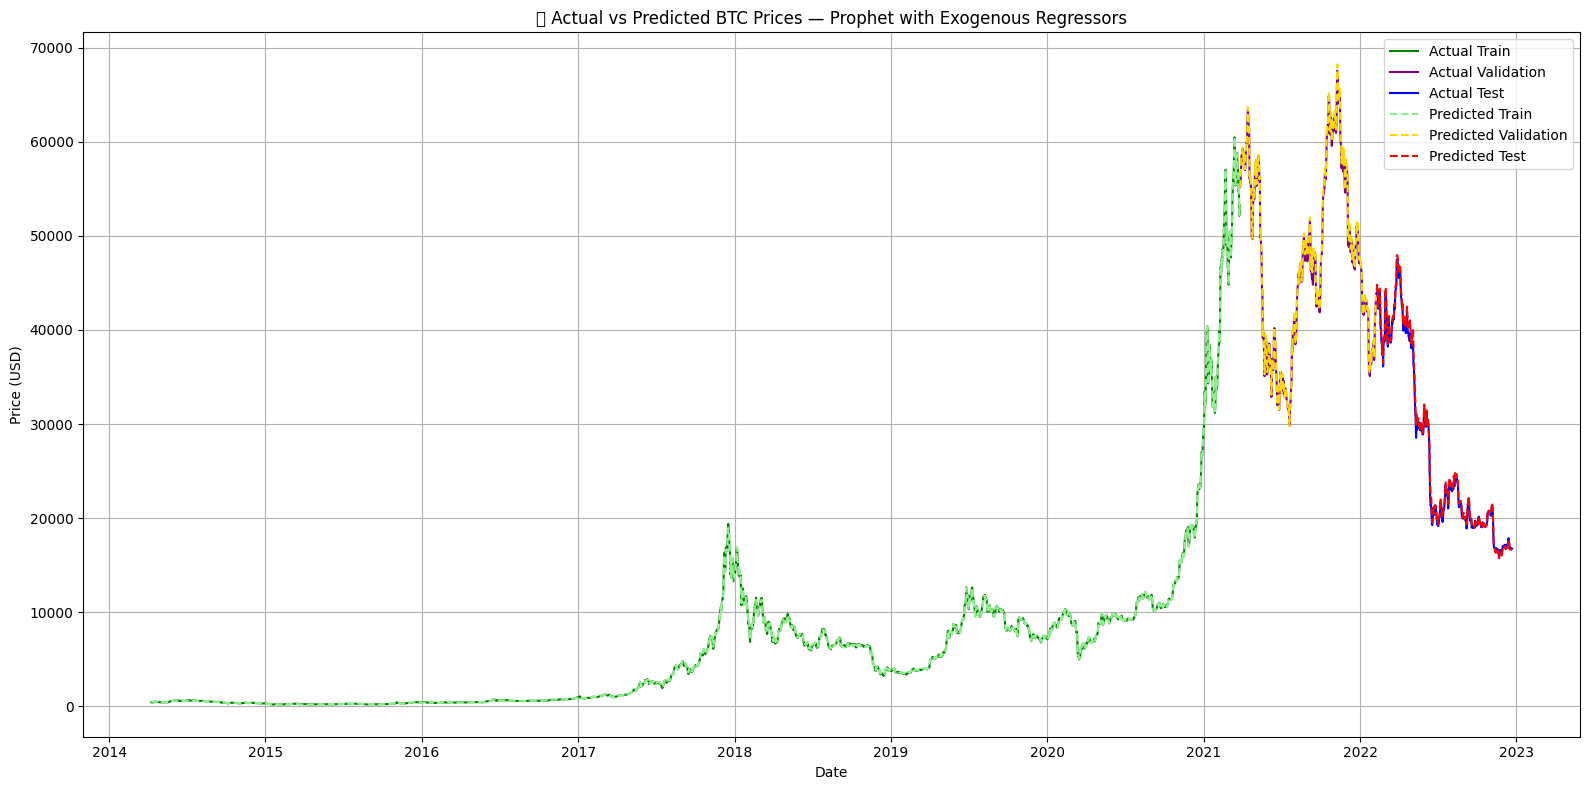

In [11]:
# Trích y_true và y_pred cho từng tập
train_y_true = train_df['y']
train_y_pred = train_pred['yhat']

val_y_true = val_df['y']
val_y_pred = val_forecast_best['yhat']

test_y_true = test_df['y']
test_y_pred = test_forecast['yhat']

# === Biểu đồ: Actual vs Predicted cho Train, Validation, Test ===
plt.figure(figsize=(16, 8))

# Actual lines
plt.plot(train_df['ds'], train_y_true, label='Actual Train', color='green')
plt.plot(val_df['ds'], val_y_true, label='Actual Validation', color='purple')
plt.plot(test_df['ds'], test_y_true, label='Actual Test', color='blue')

# Predicted lines
plt.plot(train_df['ds'], train_y_pred, label='Predicted Train', color='lightgreen', linestyle='--')
plt.plot(val_df['ds'], val_y_pred, label='Predicted Validation', color='gold', linestyle='--')
plt.plot(test_df['ds'], test_y_pred, label='Predicted Test', color='red', linestyle='--')

# Format
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('📊 Actual vs Predicted BTC Prices — Prophet with Exogenous Regressors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


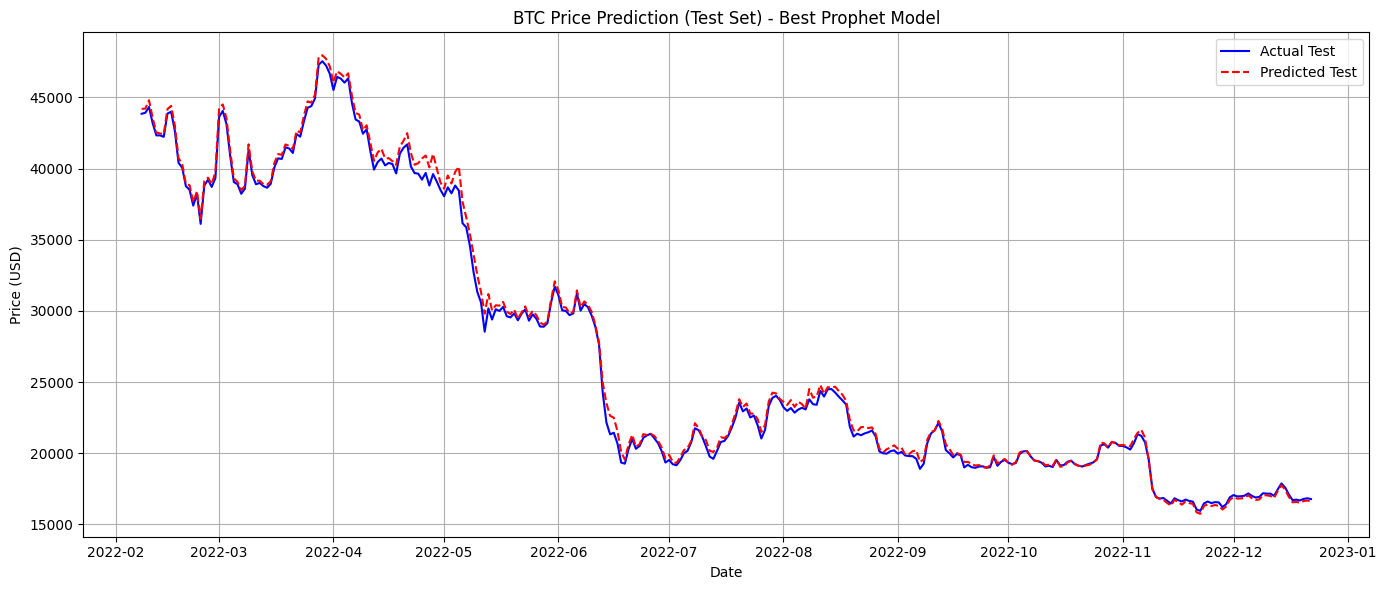

In [12]:
# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual Test', color='blue')
plt.plot(test_df['ds'], test_forecast['yhat'], label='Predicted Test', color='red', linestyle='--')
plt.title('BTC Price Prediction (Test Set) - Best Prophet Model')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()